In [168]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
import pandas as pd
import sklearn
from sklearn import svm

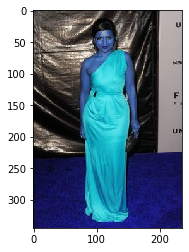

In [165]:
for person in os.listdir("./celebrity_image/train/"):
    Path=os.path.join("./celebrity_image/train/",person)
    for img in os.listdir(Path):
        im=cv2.imread(Path+"/"+img)
        plt.imshow(im)
        

In [136]:
face_haarcas=cv2.CascadeClassifier("./opencv_data/haarcascade_frontalface_default.xml")
eye_haarcas=cv2.CascadeClassifier("./opencv_data/haarcascade_eye.xml")

In [137]:
faces=face_haarcas.detectMultiScale(im,1.3,5)
faces

array([[97, 31, 35, 35]], dtype=int32)

In [138]:
(x,y,w,h)=faces[0]
x,y,w,h

(97, 31, 35, 35)

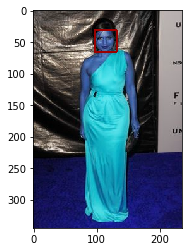

In [139]:
face_img=cv2.rectangle(im,(x,y),(x+w,y+h),(155,0,0),2)
plt.imshow(face_img)

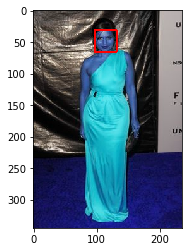

In [140]:
for (x,y,w,h) in faces:
    face_img=cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray=im[y:y+h,x:x+w]
    roi_color=face_img[y:y+h,x:x+w]
    eyes=eye_haarcas.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(im,cmap="gray")
plt.show()

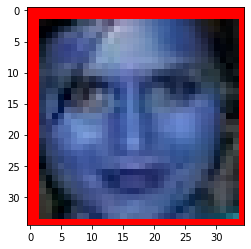

In [141]:
plt.imshow(roi_color,cmap="gray")

In [142]:
def get_cropped_image_if_2_eyes(image_path):
    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_haarcas.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=img[y:y+h,x:x+w]
        eyes=eye_haarcas.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

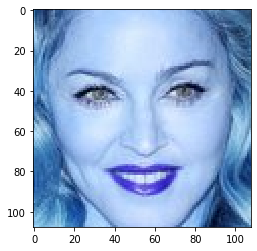

In [143]:
cropped_image=get_cropped_image_if_2_eyes("./celebrity_image/train/madonna/madonna0.jpg")
plt.imshow(cropped_image)

In [144]:
path_to_dir="./celebrity_image/train/"
path_to_cr_data="./celebrity_image/cropped/"

In [145]:
img_dirs=[]
for entry in os.scandir(path_to_dir):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [146]:
img_dirs

['./celebrity_image/train/ben_afflek',
 './celebrity_image/train/elton_john',
 './celebrity_image/train/jerry_seinfeld',
 './celebrity_image/train/madonna',
 './celebrity_image/train/mindy_kaling']

In [147]:
cropped_image_dirs=[]
celebrity_file_names_dict={}
count=0
for img_dir in img_dirs:
    celebrity_name=img_dir.split("/")[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name]=[]
    for entry in os.scandir(img_dir):
        roi_color=get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder=path_to_cr_data+celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Genterating cropped image in folder ",cropped_folder)
            
            cropped_file_name=celebrity_name+str(count)+".jpg"
            cropped_file_path=cropped_folder+"/"+cropped_file_name
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1

ben_afflek
elton_john
jerry_seinfeld
madonna
mindy_kaling


In [148]:
def w2d(img, mode='haar', level=1):
    imArray = img
#     imArray=cv2.imread(img)
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    #Display result
    return imArray

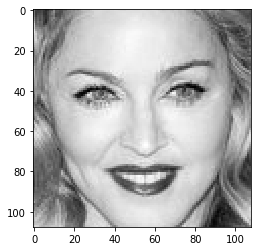

In [149]:
im_har=w2d(cropped_image,"db1",5)
plt.imshow(im_har,cmap="gray")

In [150]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count+=1
class_dict

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [151]:
X=[]
y=[]
for celebrity_name,training_file in celebrity_file_names_dict.items():
    for training_image in training_file:
        img=cv2.imread(training_image)
        scalled_raw_img=cv2.resize(img,(32,32))
        img_har=w2d(img,"db1",5)
        scalled_img_har=cv2.resize(img_har,(32,32))
        combined_img=np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [152]:
len(X[0])

4096

In [153]:
x=np.array(X).reshape(len(X),4096).astype(float)

In [154]:
Y=np.array(y)

In [155]:
Y

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [156]:
X_train,X_test,y_train,y_test=train_test_split(x,Y,random_state=0)

In [157]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((29, 4096), (10, 4096), (29,), (10,))

In [158]:
pipe=Pipeline([("scaler",StandardScaler()),("svc",SVC(kernel="rbf",C=10))])

In [159]:
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.8

In [160]:
len(X_test)

10

In [161]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         1
           4       1.00      0.83      0.91         6

    accuracy                           0.80        10
   macro avg       0.62      0.71      0.64        10
weighted avg       0.80      0.80      0.78        10



c:\users\parikalp\appdata\local\programs\python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [172]:
model_params={
    "svm":{
        "model":svm.SVC(gamma="auto",probability=True),
        "params":{
            "svc__C":[1,10,100,1000],
            "svc__kernel":["rbf","linear"]
        }
    },
    "random_forest":{
        "model":RandomForestClassifier(),
        "params":{
            "randomforestclassifier__n_estimators":[1,5,10]
        }
    },
    "logistic_regression":{
        "model":LogisticRegression(solver="liblinear",multi_class="auto"),
        "params":{
            "logisticregression__C":[1,5,10]
        }
    }
}

In [174]:
score=[]
best_estimators={}
for algo,mp in model_params.items():
    pipe=make_pipeline(StandardScaler(),mp["model"])
    clf=GridSearchCV(pipe,mp["params"],cv=5,return_train_score=False)
    clf.fit(X_train,y_train)
    score.append({
        "model":algo,
        "best_score":clf.best_score_,
        "best_params":clf.best_params_
    })
    best_estimators[algo]=clf.best_estimator_
    
df=pd.DataFrame(score,columns=["model","best_score","best_params"])
df

c:\users\parikalp\appdata\local\programs\python\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\users\parikalp\appdata\local\programs\python\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\users\parikalp\appdata\local\programs\python\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


,model,best_score,best_params
0,svm,0.689655,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.551724,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.517241,{'logisticregression__C': 1}


In [175]:
best_estimators["svm"].score(X_test,y_test)

0.8

In [176]:
best_estimators["random_forest"].score(X_test,y_test)

0.5

In [177]:
best_estimators["logistic_regression"].score(X_test,y_test)

0.9

In [178]:
best_clf=best_estimators["svm"]

In [181]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[0, 1, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 5]], dtype=int64)

Text(69.0, 0.5, 'Truth')

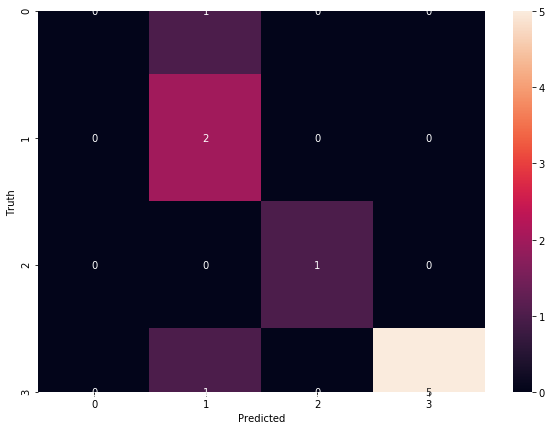

In [182]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [183]:
class_dict

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [187]:
import joblib
joblib.dump(best_clf,"celebrity_image_saved_model.pkl")

['celebrity_image_saved_model.pkl']

In [188]:
import json
with open("celebrity_class_dictionary","w")as f:
    f.write(json.dumps(class_dict))